# Data Cleaning using Spark Streaming

[Apache Spark](https://spark.apache.org/) is a unified analytics engine for large-scale data processing. It gives you a high-level API to do high-performant data processing. 

The previous lab showed how to use Apache Spark to process large amounts of data at rest. However, Spark also has two API's for processing continuous streams of data. 



"[Spark streaming](https://spark.apache.org/docs/latest/streaming-programming-guide.html)" is the original RDD-based streaming API which uses Discrete Streams (DStreams). "[Spark structured streaming](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)" is the newer DataFrame-based API which provides more high-level concepts to work with and does a lot more automatic performance optimization.

The original DStream api is not a *true* streaming api because it doesn't process events immediately as it recieves them. The DStream API works on a micro batch; Spark polls the event source after every batch duration and processes all events since the last poll once. This means that, if your batch duration is 30 seconds, it might take 30 seconds for an event to be processed in the worst case.

[More info on DStreams vs structured streams](https://blog.knoldus.com/spark-streaming-vs-structured-streaming/)

## DataFrames

Just like the Python Pandas framework, Apache Spark also provides a [DataFrames API](https://spark.apache.org/docs/latest/sql-getting-started.html), which we'll be using for this lab. The DataFrames API is much more high-level compared to the RDD api. **A DataFrame represents a table of data with rows, collumns and a schema.** This table can span hundreds of servers and all queries you execute on a DataFrame are distributed over all the servers where it resides.

Have a couple of advantages over RDD's.

* More high-level query api, for example DataFrames support transformations like group-by: `df.groupBy("age").count().show()`.
* Support for SQL queries.
* [Lazy evaluation](https://data-flair.training/blogs/apache-spark-lazy-evaluation/). Most operations on a DataFrame return a transformed DataFrame. This transformation isn't executed immediately, however. You can keep building the query by transforming the dataframes. Only when an action is triggered, for example by loading the result of a transformation into a database, does Spark build and execute the resulting transformation as efficiently as possible. C# developers might know this concept from LINQ, which works in a similar way.

## Spark Structured Streaming

The key idea in Structured Streaming is to treat a live data stream as a table that is being continuously appended. This leads to a new stream processing model that is very similar to a batch processing model. You express your streaming computation as standard batch-like query as on a static table, and Spark runs it as an *incremental* query on the *unbounded* input table. Let’s understand this model in more detail in context of this example program which performs a word count on a stream of sentences.

```python
val lines = spark.readStream
  .format("socket")
  .option("host", "localhost")
  .option("port", 9999)
  .load()

// Split the lines into words
val words = lines.as[String].flatMap(_.split(" "))

// Generate running word count
val wordCounts = words.groupBy("value").count()
```

### Basic Concepts

Consider the input data stream as the “Input Table”. Every data item that is arriving on the stream is like a new row being appended to the Input Table.

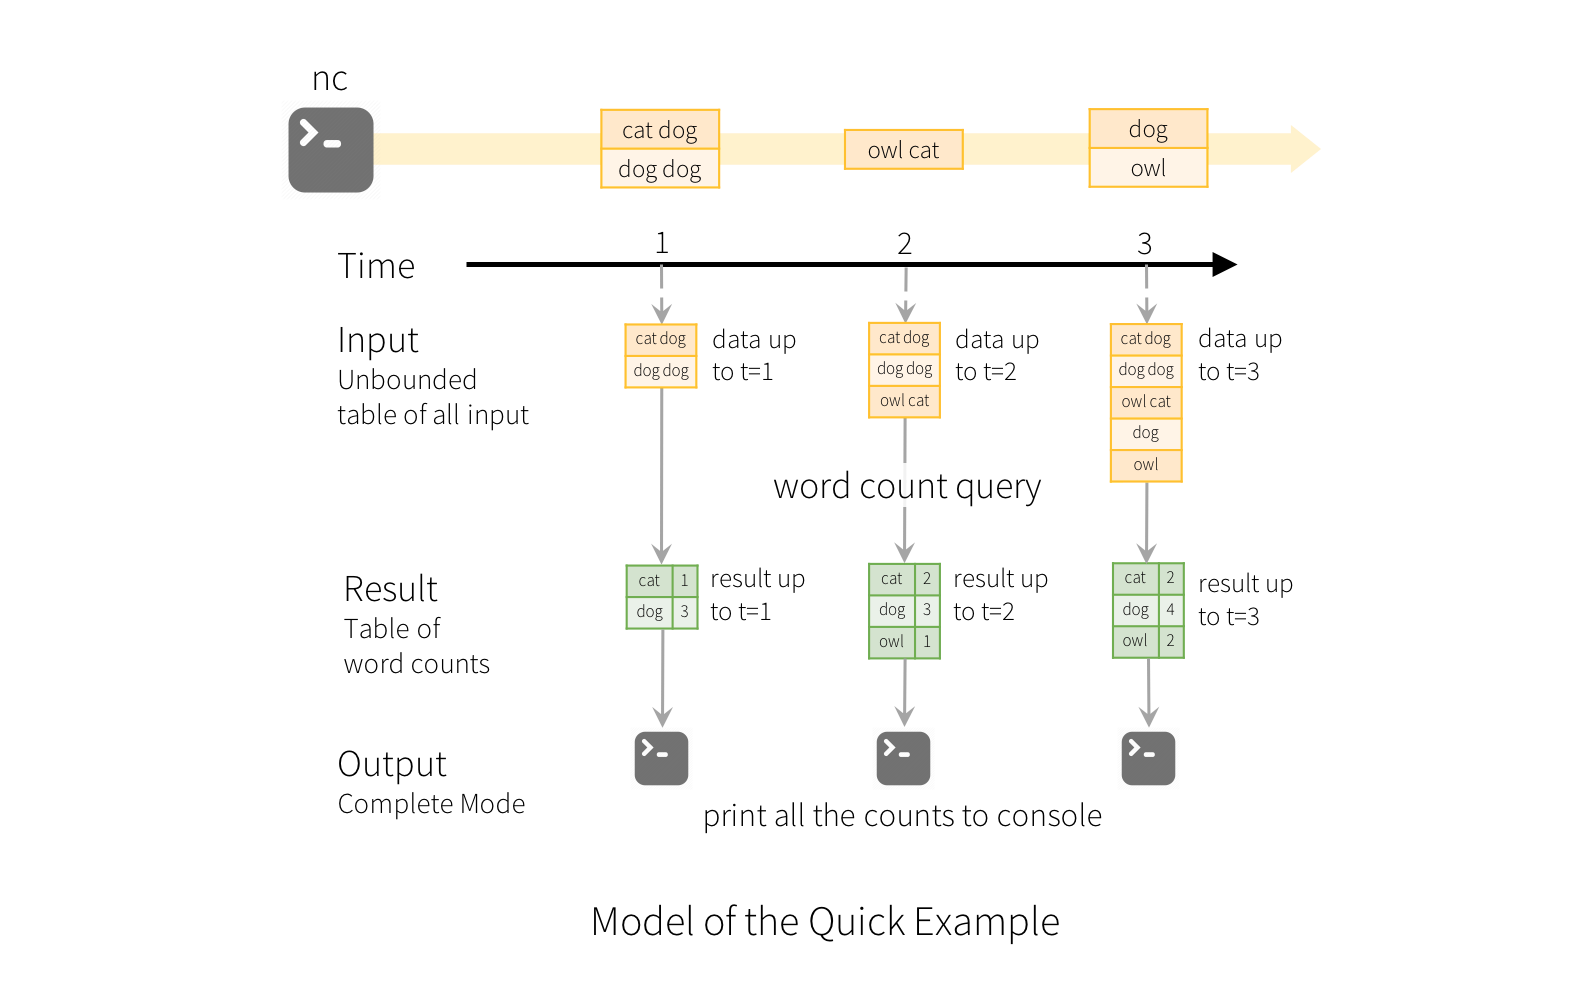

A query on the input will generate the “Result Table”. Every trigger interval (say, every 1 second), new rows get appended to the Input Table, which eventually updates the Result Table. Whenever the result table gets updated, we would want to write the changed result rows to an external sink.

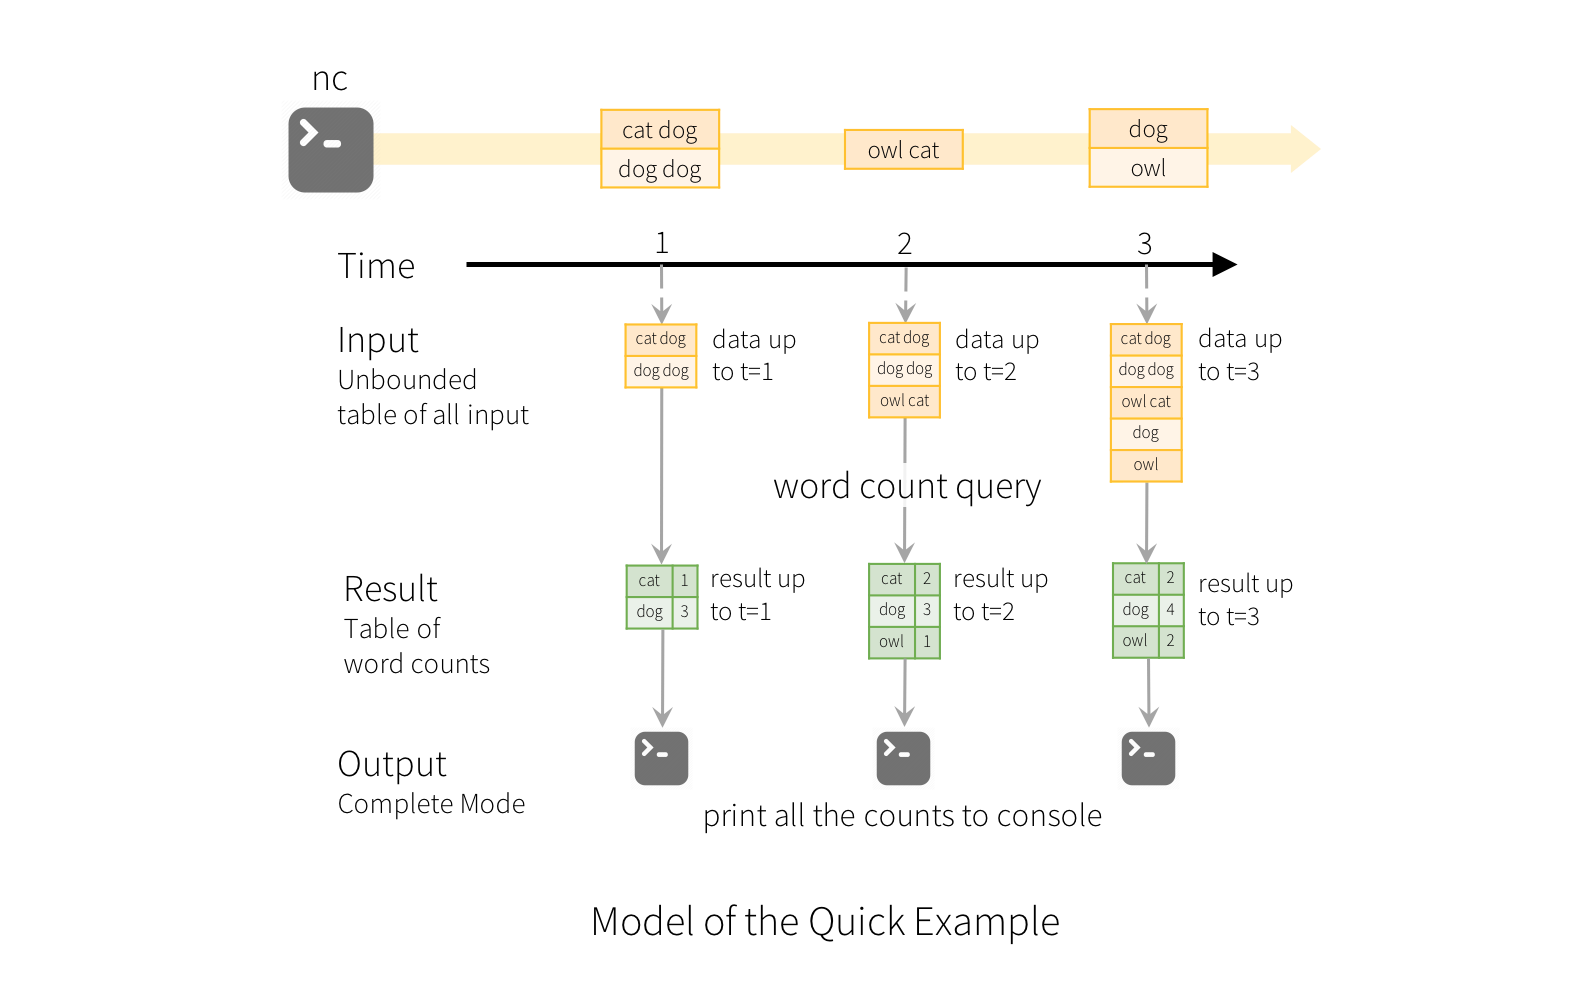

The “Output” is defined as what gets written out to the external storage. The output can be defined in a different mode:



* *Complete Mode* - The entire updated Result Table will be written to the external storage. It is up to the storage connector to decide how to handle writing of the entire table.
* *Append Mode* - Only the new rows appended in the Result Table since the last trigger will be written to the external storage. This is applicable only on the queries where existing rows in the Result Table are not expected to change.
* *Update Mode* - Only the rows that were updated in the Result Table since the last trigger will be written to the external storage (available since Spark 2.1.1). Note that this is different from the Complete Mode in that this mode only outputs the rows that have changed since the last trigger. If the query doesn’t contain aggregations, it will be equivalent to Append mode.

Note that each mode is applicable on certain types of queries. This is discussed in detail [in the docs](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#output-modes).

To illustrate the use of this model, let’s understand the model in context of the example program from before.

```python
val lines = spark.readStream
  .format("socket")
  .option("host", "localhost")
  .option("port", 9999)
  .load()

// Split the lines into words
val words = lines.as[String].flatMap(_.split(" "))

// Generate running word count
val wordCounts = words.groupBy("value").count()
```

The `lines` DataFrame is the input table, and the final `wordCounts` DataFrame is the result table. Note that the query on streaming `lines` DataFrame to generate `wordCounts` is *exactly the same* as it would be a static DataFrame. However, when this query is started, Spark will continuously check for new data from the socket connection. If there is new data, Spark will run an “incremental” query that combines the previous running counts with the new data to compute updated counts, as shown below.

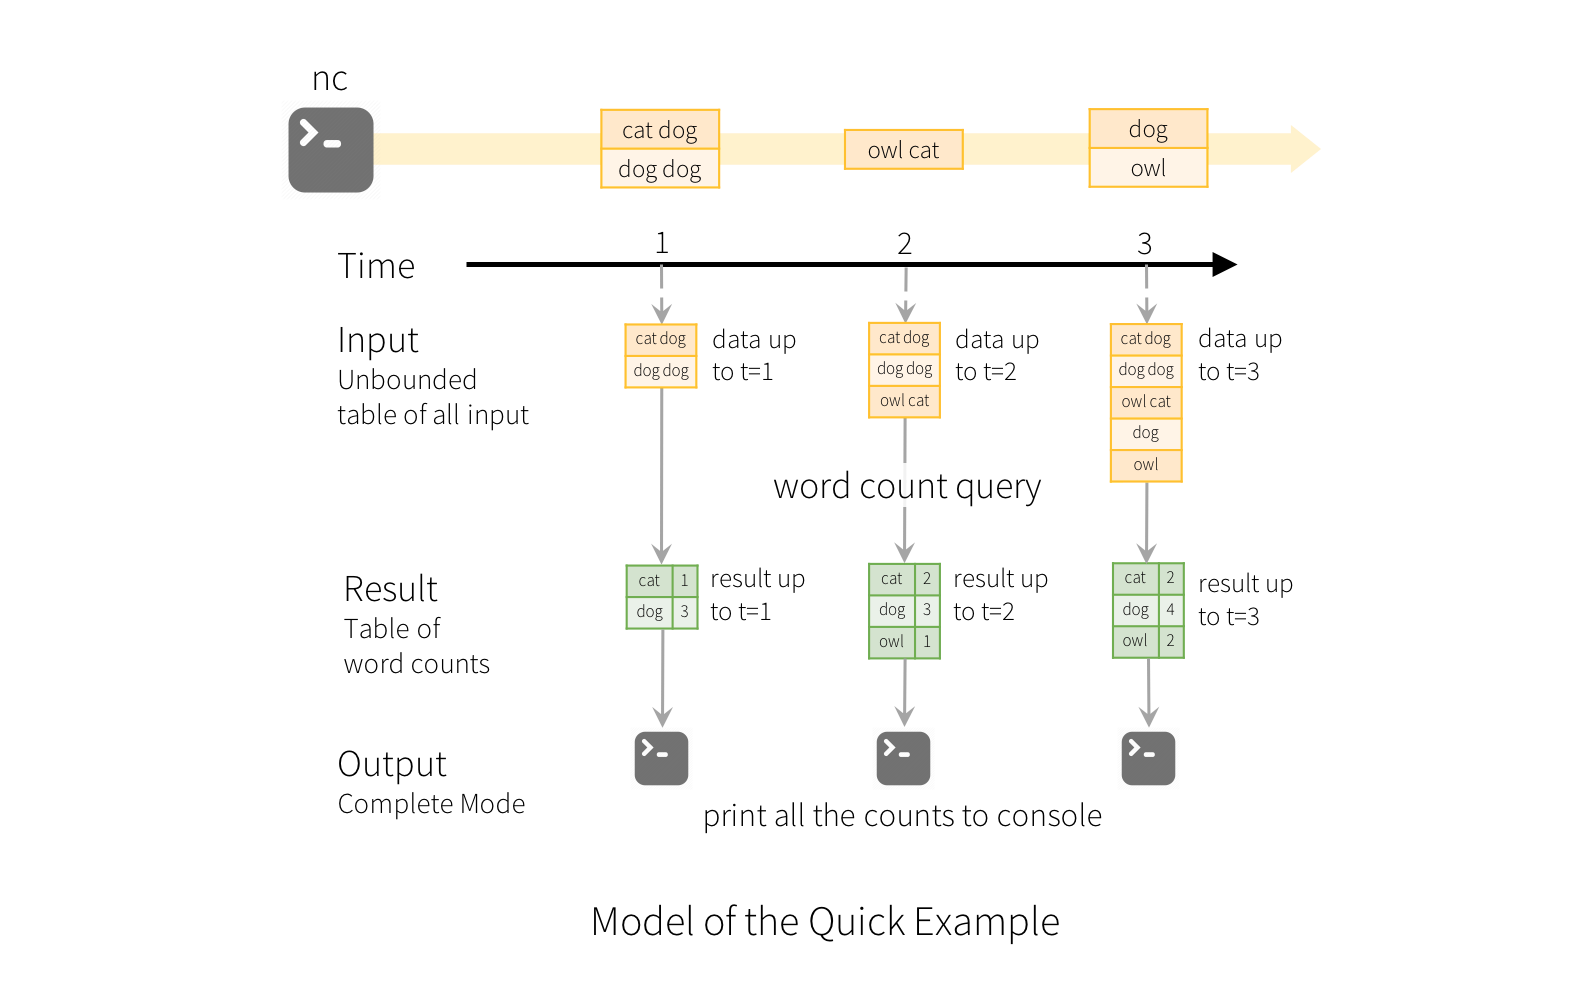

**Note that Structured Streaming does not materialize the entire table.** It reads the latest available data from the streaming data source, processes it incrementally to update the result, and then discards the source data. It only keeps around the minimal intermediate state data as required to update the result (e.g. intermediate counts in the earlier example).

This model is significantly different from many other stream processing engines. Many streaming systems require the user to maintain running aggregations themselves, thus having to reason about fault-tolerance, and data consistency (at-least-once, or at-most-once, or exactly-once). In this model, Spark is responsible for updating the Result Table when there is new data, thus relieving the users from reasoning about it.


# Exercise


In this exercise, we'll use the new Spark structured streaming API to clean the page view event stream. The following operations need to happen.

* Remove messages that don't have a timestamp or that whose timestamp is 0.
* Cast all country codes to uppercase.
* Remove all countries except Belgium

The resulting stream will be sent back to kafka, in a new topic `clicks-cleaned`.

* Refer to the [Spark structured streaming programming guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html) for more information on how to use this API.
* The book [Spark: The Definitive Guide](http://shop.oreilly.com/product/0636920034957.do) ([Download PDF](https://github.com/achinnasamy/bigdata/raw/master/Spark%20-%20The%20Definitive%20Guide%20-%20Big%20data%20processing%20made%20simple.pdf)) provides an even more in-depth view of how to use Spark.

In [1]:
%%bash
# Ensure the required Python 3 dependencies are installed.
python3 -m pip install kafka-python

Create a Spark context and specify that the python spark-kafka libraries need to be added.

In [2]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.3 pyspark-shell'

import pyspark 
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *


sc = SparkContext()
sc.setLogLevel("WARN")
spark = SparkSession(sc)

Create a streaming DataFrame that represents the events recieved from the Kafka topic `clicks`. We'll use [the `spark-sql-kafka` connector](https://spark.apache.org/docs/latest/structured-streaming-kafka-integration.html) for this. This results in a dataframe with two columns: `key` and `value` which are casted as strings.

In [ ]:
df = spark.readStream.format("kafka") \
    .option("kafka.bootstrap.servers","localhost:9092") \
    .option("subscribe", "clicks") \
    .option("startingOffsets", "earliest") \
    .load()
df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

The second step is to cast the json to columns in the DataFrame. We'll manually specify the schema of the object using the [from_json](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.from_json) function and specifying the schema as a [`StructType`](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.types.StructType).

In [ ]:
schema = StructType([
    StructField("visitor_platform", StringType()),
    StructField("ts_ingest", LongType()),
    StructField("article_title", StringType()),
    StructField("visitor_country", StringType()),
    StructField("visitor_os", StringType()),
    StructField("article", StringType()),
    StructField("visitor_browser", StringType()),
    StructField("visitor_page_timer", IntegerType()),
    StructField("visitor_page_height", IntegerType()),
])

dfs = df.selectExpr("CAST(value AS STRING)") \
      .select(from_json(col("value"), schema) \
      .alias("clicks"))

df_data = dfs.select("clicks.*")

Use a [`DataFrameNaFunction`](https://spark.apache.org/docs/2.2.0/api/java/org/apache/spark/sql/DataFrameNaFunctions.html) to drop all rows with invalid values. For more information look at the chapter "Working with Nulls in Data" in the "Spark: The Definitive Guide" book.

In [ ]:
# Drop row if it has a null field (https://spark.apache.org/docs/2.2.0/api/java/org/apache/spark/sql/DataFrameNaFunctions.html)
df_data = df_data.na.drop()

TODO: Why do we do this?

In [ ]:
# Alter column ts_ingest to convert epochs (milli) to yyyy-mm-dd HH:MM:ss format
df_DateConvertedString = df_data.withColumn("ts_ingest", from_unixtime(df_data['ts_ingest']/1000))
# ts_ingest column is of type String, needs to be converted to TimestampType
df_DateConverted = df_DateConvertedString.withColumn('ts_ingest', to_timestamp(df_DateConvertedString['ts_ingest'].cast(dataType=TimestampType())))


Use `withColumn()` to convert all `visitor_country` fields to uppercase.

In [ ]:
# Ensure that country codes are upper case
df_end = df_DateConverted.withColumn("visitor_country", upper(df_DateConverted['visitor_country']))

Use a `filter` to drop all records whose country is not `BE`.

In [ ]:
# Filter out only BE and NL clicks
df_be = df_end.filter((col("visitor_country") == 'BE') | (col("visitor_country") == 'NL'))

In [ ]:
#Debug to terminal
# query = df_be.writeStream.outputMode("append").option("truncate", "false").format("console").start()

And finally, run the continuous query.

In [ ]:
# Prepare df for Kafka and write to kafka
query = df_be.selectExpr("to_json(struct(*)) as value") \
    .writeStream.format("kafka") \
    .option("kafka.bootstrap.servers", "10.10.139.63:9092") \
    .option("topic", "calculated") \
    .option("checkpointLocation", "checkpoints") \
    .start()
query.awaitTermination()